In [32]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import wandb
import os
import matplotlib.dates as mdates

# Results
Get results from Weights and Biases and produce plots for paper

In [3]:
def get_data_from_wandb():

    api = wandb.Api()

    # Project is specified by <entity/project-name>
    runs = api.runs("messer/JavaDoc-Relevance-Binary-Classifier")

    summary_list, config_list, name_list, group_list, tag_list = [], [], [], [], []
    for run in runs:
        # .summary contains the output keys/values for metrics like accuracy.
        #  We call ._json_dict to omit large files
        summary_list.append(run.summary._json_dict)

        # .config contains the hyperparameters.
        #  We remove special values that start with _.
        config_list.append(
            {k: v for k,v in run.config.items()
             if not k.startswith('_')})

        # .name is the human-readable name of the run.
        name_list.append(run.name)
        group_list.append(run.group)
        tag_list.append(run.tags)

    runs_df = pd.DataFrame({
        "summary": summary_list,
        "config": config_list,
        "name": name_list,
        "group": group_list,
        "tag": tag_list
    })

    runs_df.to_csv("data/training_results.csv")
    return runs_df

if not os.path.isfile("data/training_results.csv"):
    runs_df = get_data_from_wandb()

### Process WandB API call results

In [4]:
runs_df = pd.read_csv('data/training_results.csv')
runs_df['summary'] = runs_df['summary'].apply(lambda s: eval(s))
runs_df['config'] = runs_df['config'].apply(lambda s: eval(s))
runs_df.head()

,Unnamed: 0,summary,config,name,group,tag
0,0,"{'test/loss': 1.736921310424805, 'train/train_...","{'bf16': False, 'fp16': False, 'fsdp': '[]', '...",breezy-elevator-1389,LORA:bert-base-uncased,"['DEV', 'no custom weights', 'preprocessed']"
1,1,"{'_wandb': {'runtime': 787}, 'train/epoch': 10...","{'bf16': False, 'fp16': False, 'fsdp': '[]', '...",vocal-shadow-1388,LORA:bert-base-uncased,"['DEV', 'no custom weights', 'preprocessed']"
2,2,"{'test/f1_macro': 0.7913120207992567, 'test/f1...","{'bf16': False, 'fp16': False, 'fsdp': '[]', '...",still-field-1387,LORA:bert-base-uncased,"['DEV', 'no custom weights', 'preprocessed']"
3,3,"{'_runtime': 7855.414884567261, 'eval/loss': 0...","{'bf16': False, 'fp16': False, 'fsdp': '[]', '...",blooming-feather-1386,LORA:bert-base-uncased,"['no custom weights', 'preprocessed']"
4,4,"{'eval/precision_micro': 1, 'eval/recall_weigh...","{'bf16': False, 'fp16': False, 'fsdp': '[]', '...",volcanic-cherry-1385,LORA:bert-base-uncased,"['no custom weights', 'preprocessed']"


In [5]:
df = pd.concat([runs_df[['name', 'group', 'config', 'tag']], pd.json_normalize(runs_df['summary'])], axis=1)

df.head()

,name,group,config,tag,test/loss,train/train_loss,eval/precision_macro,train/train_samples_per_second,eval/f1_macro,test/steps_per_second,...,test/recall_weighted,train/loss,eval/runtime,test/runtime,test/f1_micro,eval/precision_micro,_wandb.runtime,test/latency_in_seconds,test/total_time_in_seconds,split
0,breezy-elevator-1389,LORA:bert-base-uncased,"{'bf16': False, 'fp16': False, 'fsdp': '[]', '...","['DEV', 'no custom weights', 'preprocessed']",1.736921,0.000114,1.000000,51.027,1.000000,8.669,...,0.841121,0.0000,0.3817,0.8075,0.841121,1.000000,3828.0,NaN,NaN,NaN
1,vocal-shadow-1388,LORA:bert-base-uncased,"{'bf16': False, 'fp16': False, 'fsdp': '[]', '...","['DEV', 'no custom weights', 'preprocessed']",1.125602,0.000282,1.000000,48.676,1.000000,4.774,...,0.850467,NaN,0.3775,0.8379,0.850467,1.000000,787.0,NaN,NaN,NaN
2,still-field-1387,LORA:bert-base-uncased,"{'bf16': False, 'fp16': False, 'fsdp': '[]', '...","['DEV', 'no custom weights', 'preprocessed']",1.594745,0.001584,1.000000,49.334,1.000000,4.762,...,0.794393,0.0018,0.3825,0.8400,0.794393,1.000000,3926.0,NaN,NaN,NaN
3,blooming-feather-1386,LORA:bert-base-uncased,"{'bf16': False, 'fp16': False, 'fsdp': '[]', '...","['no custom weights', 'preprocessed']",0.744029,0.319069,0.954167,49.120,0.950973,4.771,...,0.775701,0.2967,0.3675,0.8384,0.775701,0.952381,7854.0,NaN,NaN,NaN
4,volcanic-cherry-1385,LORA:bert-base-uncased,"{'bf16': False, 'fp16': False, 'fsdp': '[]', '...","['no custom weights', 'preprocessed']",0.773704,0.376419,1.000000,61.913,1.000000,9.525,...,0.794393,0.3705,0.3482,0.7349,0.794393,1.000000,3150.0,NaN,NaN,NaN


### Group and produce plots

In [6]:
grey = (187/255, 187/255, 187/255)
darkgreen = (51/255, 117/255, 56/255)
teal = (93/255, 168/255, 153/255)
blue = (148/255, 203/255, 236/255)
yellow = (220/255, 205/255, 125/255)

In [7]:
grouped_df = df[['group', 'test/accuracy', 'test/precision_weighted', 'test/recall_weighted', 'test/f1_weighted']].groupby('group').max().reset_index()
grouped_df.columns = ['group', 'accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']

grouped_df

,group,accuracy,precision_weighted,recall_weighted,f1_weighted
0,Bernolli,0.682243,0.692127,0.682243,0.680198
1,DecisionTree,0.616822,0.617826,0.616822,0.604051
2,Fine-Tuned LLM:bert-base-uncased,0.831776,0.834950,0.831776,0.829608
3,Fine-Tuned LLM:microsoft/codebert-base,0.887850,0.896011,0.887850,0.885536
4,KNeighbours,0.785047,0.796421,0.785047,0.783630
5,LORA:bert-base-uncased,0.850467,0.847648,0.850467,0.846698
6,LORA:microsoft/codebert-base,0.831776,0.843810,0.831776,0.830154
7,LogisticRegression,0.785047,0.791682,0.785047,0.775506
8,RandomForest,0.850467,0.865247,0.850467,0.833577


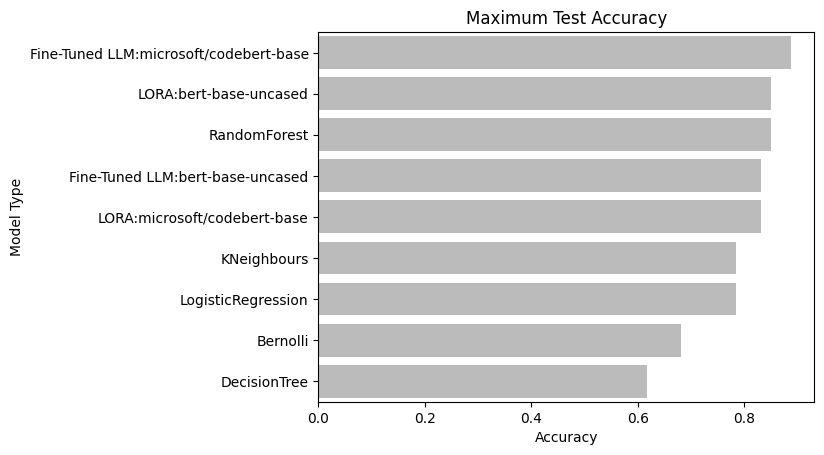

In [8]:
acc = sns.barplot(grouped_df[['group', 'accuracy']].sort_values('accuracy', ascending=False), y='group', x='accuracy', color=grey)
acc.set(title='Maximum Test Accuracy', xlabel='Accuracy', ylabel='Model Type')
acc.get_figure().savefig('plots/accuracy.pdf', bbox_inches='tight')

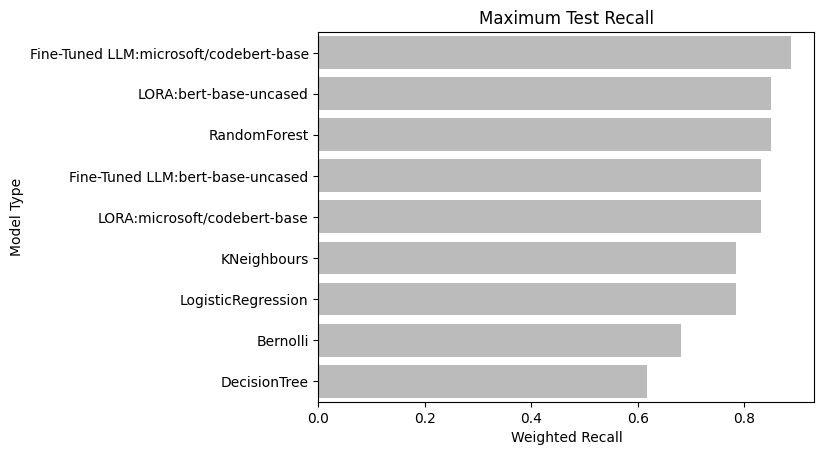

In [9]:
recall = sns.barplot(grouped_df[['group', 'recall_weighted']].sort_values('recall_weighted', ascending=False), y='group', x='recall_weighted', color=grey)
recall.set(title='Maximum Test Recall', xlabel='Weighted Recall', ylabel='Model Type')
recall.get_figure().savefig('plots/recall.pdf', bbox_inches='tight')

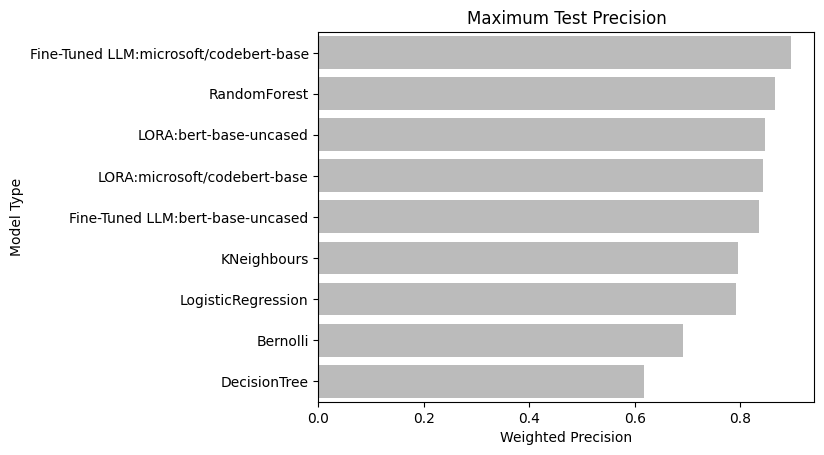

In [10]:
precision = sns.barplot(grouped_df[['group', 'precision_weighted']].sort_values('precision_weighted', ascending=False), y='group', x='precision_weighted', color=grey)
precision.set(title='Maximum Test Precision', xlabel='Weighted Precision', ylabel='Model Type')
precision.get_figure().savefig('plots/precision.pdf', bbox_inches='tight')

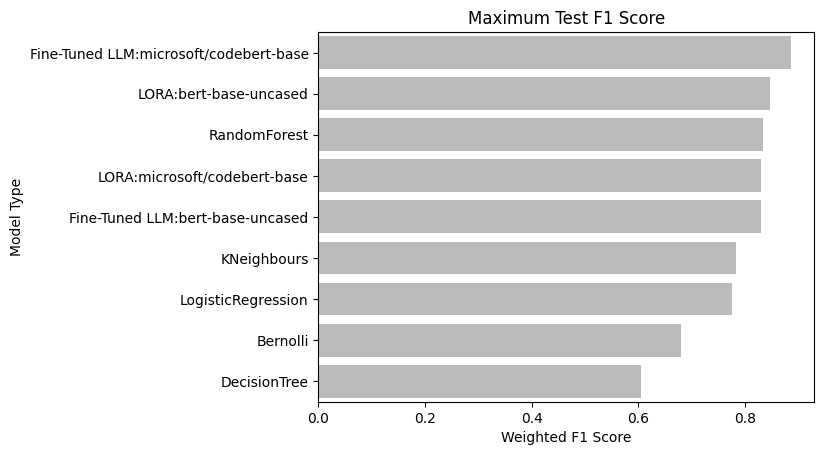

In [11]:
f1 = sns.barplot(grouped_df[['group', 'f1_weighted']].sort_values('f1_weighted', ascending=False), y='group', x='f1_weighted', color=grey)
f1.set(title='Maximum Test F1 Score', xlabel='Weighted F1 Score', ylabel='Model Type')
f1.get_figure().savefig('plots/f1.pdf', bbox_inches='tight')

In [12]:
grouped_df_melted = grouped_df.melt(id_vars=['group'])
grouped_df_melted['variable'] = grouped_df_melted['variable'].map(lambda metric_name: metric_name.title().replace('_Weighted', ''))
grouped_df_melted

,group,variable,value
0,Bernolli,Accuracy,0.682243
1,DecisionTree,Accuracy,0.616822
2,Fine-Tuned LLM:bert-base-uncased,Accuracy,0.831776
3,Fine-Tuned LLM:microsoft/codebert-base,Accuracy,0.887850
4,KNeighbours,Accuracy,0.785047
5,LORA:bert-base-uncased,Accuracy,0.850467
6,LORA:microsoft/codebert-base,Accuracy,0.831776
7,LogisticRegression,Accuracy,0.785047
8,RandomForest,Accuracy,0.850467
9,Bernolli,Precision,0.692127


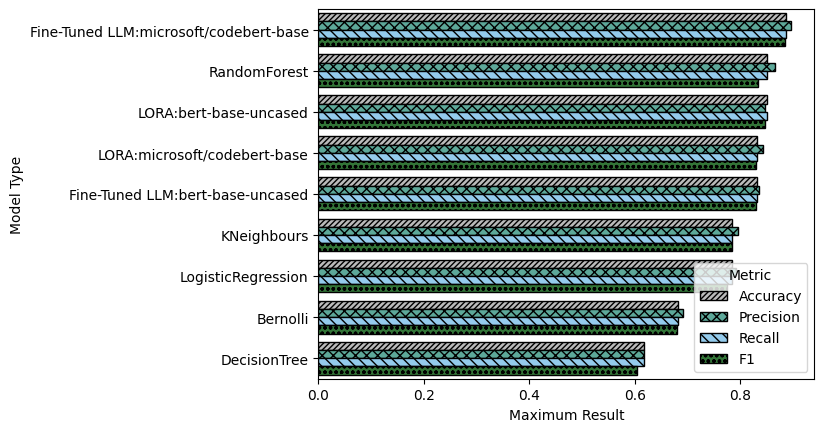

In [13]:
metrics = sns.barplot(grouped_df_melted.sort_values(['value'], ascending=False), y='group', x='value', hue='variable', hue_order=['Accuracy', 'Precision', 'Recall', 'F1'])


hatches = ['//', 'x', '\\', 'o']
colors = [grey, teal, blue, darkgreen]
styles = zip(hatches, colors)


for style, these_bars in zip(styles, metrics.containers):
    for this_bar in these_bars:
        this_bar.set_hatch(3 * style[0])
        this_bar.set_facecolor(style[1])
        this_bar.set_edgecolor('black')

metrics.set(xlabel='Maximum Result', ylabel='Model Type')
metrics.legend(title='Metric')

metrics.get_figure().savefig('plots/metric_results.pdf', bbox_inches='tight')

### Top results

In [14]:
top_df = df.sort_values(['test/accuracy'], ascending=False).head(100).reset_index()[['group', 'test/accuracy', 'test/precision_weighted', 'test/recall_weighted', 'test/f1_weighted', 'config', 'tag']]
top_df

,group,test/accuracy,test/precision_weighted,test/recall_weighted,test/f1_weighted,config,tag
0,Fine-Tuned LLM:microsoft/codebert-base,0.887850,0.896011,0.887850,0.885536,"{'bf16': False, 'fp16': False, 'fsdp': '[]', '...","['new_eval', 'no custom weights', 'preprocessed']"
1,Fine-Tuned LLM:microsoft/codebert-base,0.887850,0.896011,0.887850,0.885536,"{'bf16': False, 'fp16': False, 'fsdp': '[]', '...","['new_eval', 'no custom weights', 'preprocessed']"
2,Fine-Tuned LLM:microsoft/codebert-base,0.887850,0.896011,0.887850,0.885536,"{'bf16': False, 'fp16': False, 'fsdp': '[]', '...","['new_eval', 'no custom weights', 'preprocessed']"
3,Fine-Tuned LLM:microsoft/codebert-base,0.887850,0.896011,0.887850,0.885536,"{'bf16': False, 'fp16': False, 'fsdp': '[]', '...","['new_eval', 'no custom weights', 'preprocessed']"
4,Fine-Tuned LLM:microsoft/codebert-base,0.887850,0.896011,0.887850,0.885536,"{'bf16': False, 'fp16': False, 'fsdp': '[]', '...","['new_eval', 'no custom weights', 'preprocessed']"
...,...,...,...,...,...,...,...
95,RandomForest,0.738318,0.744426,0.738318,0.723663,"{'rf_max_depth': 26, 'trial.number': 7}","['pre-trained:bert-base-uncased', 'preprocessed']"
96,RandomForest,0.738318,0.749731,0.738318,0.740057,"{'rf_max_depth': 30, 'trial.number': 3}","['TfIdf', 'preprocessed']"
97,RandomForest,0.738318,0.726370,0.738318,0.729521,"{'rf_max_depth': 22, 'trial.number': 16}","['pre-trained:openai-gpt', 'preprocessed']"
98,RandomForest,0.728972,0.723818,0.728972,0.724703,"{'rf_max_depth': 28, 'trial.number': 11}","['pre-trained:microsoft/codebert-base', 'prepr..."


In [15]:
for idx, row in top_df.iterrows():
    if 'num_train_epochs' in row['config'].keys():
        print("RANK: {idx} Epochs: {epochs} Learning Rate: {lr} Batch Size: {batch_size}"
              .format(idx=idx,
                      epochs=row['config']['num_train_epochs'],
                      lr=row['config']['learning_rate'],
                      batch_size=row['config']['eval_batch_size']))
    elif 'rf_max_depth' in row['config'].keys():
        print("RANK: {idx} RF Max Depth: {max_depth}".format(idx=idx, max_depth=row['config']['rf_max_depth']))
    else:
        print("RANK: {idx} n-neighbours: {n}".format(idx=idx, n=row['config']['n_neighbours']))

RANK: 0 Epochs: 50 Learning Rate: 6.974863894936938e-05 Batch Size: 32
RANK: 1 Epochs: 10 Learning Rate: 2.8748857838210947e-06 Batch Size: 32
RANK: 2 Epochs: 10 Learning Rate: 4.2923441855476145e-06 Batch Size: 16
RANK: 3 Epochs: 100 Learning Rate: 5.024594010264738e-06 Batch Size: 32
RANK: 4 Epochs: 50 Learning Rate: 5.448171334719632e-05 Batch Size: 16
RANK: 5 Epochs: 100 Learning Rate: 8.005399110043874e-05 Batch Size: 32
RANK: 6 Epochs: 10 Learning Rate: 3.166330039387619e-06 Batch Size: 16
RANK: 7 Epochs: 50 Learning Rate: 1.809597982543859e-06 Batch Size: 16
RANK: 8 Epochs: 10 Learning Rate: 1.9677940177918867e-05 Batch Size: 16
RANK: 9 Epochs: 100 Learning Rate: 3.91534719507667e-05 Batch Size: 16
RANK: 10 Epochs: 10 Learning Rate: 2.217411660263065e-05 Batch Size: 32
RANK: 11 RF Max Depth: 12
RANK: 12 Epochs: 50 Learning Rate: 8.289654555754106e-06 Batch Size: 16
RANK: 13 Epochs: 50 Learning Rate: 5.529354092274515e-05 Batch Size: 16
RANK: 14 Epochs: 50 Learning Rate: 5.448171

KeyError: 'n_neighbours'

## Runtime Evalation

In [24]:
runtime_df = df[['group', '_runtime']]
runtime_df.columns = ['group', 'runtime']
runtime_df['timedelta'] = pd.to_timedelta(runtime_df['runtime'], unit='s')

runtime_df.head()


/var/folders/1y/6byzw1px62g2f5w7p_rhb6kh0000gn/T/ipykernel_91734/3622652944.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  runtime_df['timedelta'] = pd.to_timedelta(runtime_df['runtime'], unit='s')


,group,runtime,timedelta
0,LORA:bert-base-uncased,3835.526931,0 days 01:03:55.526930809
1,LORA:bert-base-uncased,788.525122,0 days 00:13:08.525122165
2,LORA:bert-base-uncased,3927.827453,0 days 01:05:27.827453136
3,LORA:bert-base-uncased,7855.414885,0 days 02:10:55.414884567
4,LORA:bert-base-uncased,3155.003261,0 days 00:52:35.003261089


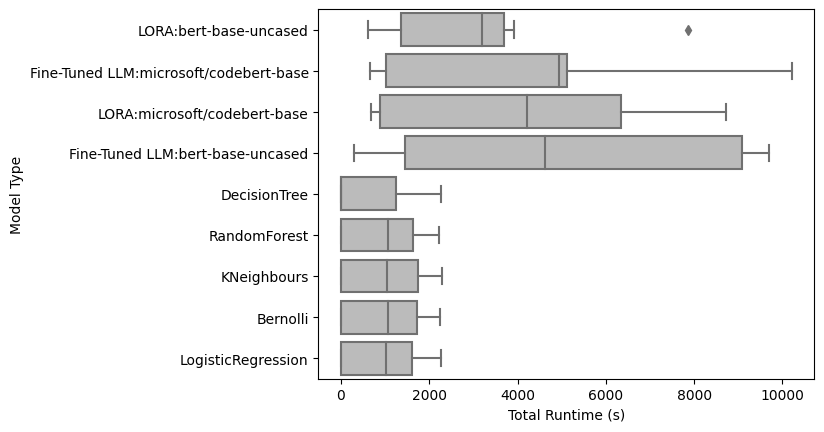

In [55]:
# TODO: Figure out how to change xaxis ticks

runtime = sns.boxplot(runtime_df, y='group', x='runtime', color=grey)
runtime.set(xlabel='Total Runtime (s)', ylabel='Model Type')

runtime.get_figure().savefig('plots/runtime.pdf', bbox_inches='tight')

## Oversampling Plot

In [69]:
raw_df = pd.read_csv('data/raw.csv')
proc_df = pd.read_csv('data/proc.csv')

raw_df.head()

,func_code_string,label,query,text
0,public static HtmlPage toHtmlPage(String strin...,3,how to get html of website,how to get html of website<CODESPLIT>public st...
1,public static HtmlPage toHtmlPage(WebDriver we...,3,how to get html of website,how to get html of website<CODESPLIT>public st...
2,public static String reverse(String string) {\...,3,how to reverse a string,how to reverse a string<CODESPLIT>public stati...
3,public HtmlElement findHtmlElementById(String ...,2,reading element from html - <td>,reading element from html - <td><CODESPLIT>pub...
4,@NonNull\n public static String getNowDateT...,3,how to get current date,how to get current date<CODESPLIT>@NonNull ...


In [70]:
raw_df['source'] = 'Raw Data'
raw_df = raw_df[['source', 'label']]

raw_df.head()

,source,label
0,Raw Data,3
1,Raw Data,3
2,Raw Data,3
3,Raw Data,2
4,Raw Data,3


<Axes: xlabel='label', ylabel='count'>

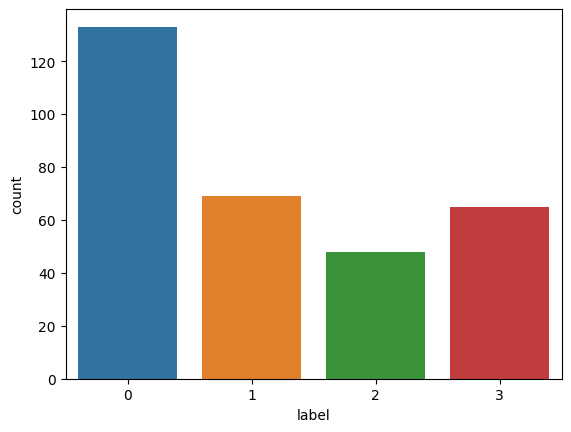

In [73]:
sns.countplot(raw_df, x='label')

In [71]:
proc_df['source'] = 'Oversampled Data'
proc_df = proc_df[['source', 'label']]

proc_df.head()

,source,label
0,Oversampled Data,0
1,Oversampled Data,1
2,Oversampled Data,2
3,Oversampled Data,3
4,Oversampled Data,0


<Axes: xlabel='label', ylabel='count'>

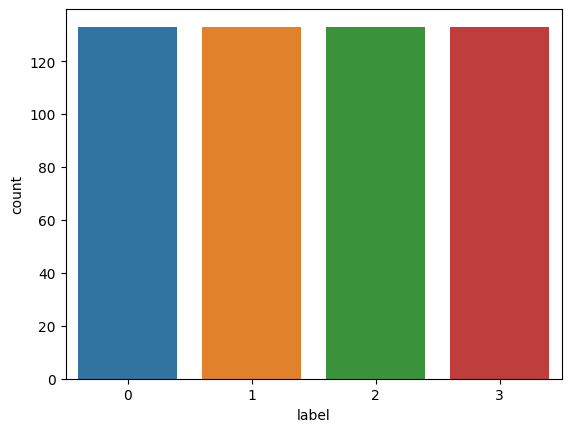

In [72]:
sns.countplot(proc_df, x='label')

In [75]:
df = pd.concat([raw_df, proc_df])
df.head()

,source,label
0,Raw Data,3
1,Raw Data,3
2,Raw Data,3
3,Raw Data,2
4,Raw Data,3


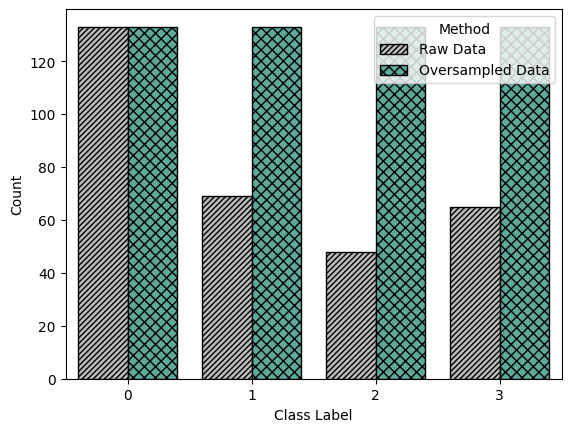

In [78]:
data_plt = sns.countplot(df, x='label', hue='source')

hatches = ['//', 'x']
colors = [grey, teal, blue, darkgreen]
styles = zip(hatches, colors)


for style, these_bars in zip(styles, data_plt.containers):
    for this_bar in these_bars:
        this_bar.set_hatch(3 * style[0])
        this_bar.set_facecolor(style[1])
        this_bar.set_edgecolor('black')

data_plt.set(xlabel='Class Label', ylabel='Count')
data_plt.legend(title='Method')

data_plt.get_figure().savefig('plots/oversampled.pdf', bbox_inches='tight')